In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev, skewness, kurtosis
from pyspark.sql.functions import expr
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
import matplotlib.pyplot as plt
import time

# Pandas ETL and Analysis for Steam Reviews Dataset

## Dataset Source and Justification
The dataset comes from game reviews on Steam. It contains information such as user ID, game ID, votes, hours played, number of reviews, and review text. It is appropriate because it allows exploring the relationship between time played, rating, review popularity, and other aspects relevant to user behavior analysis in games.

With a size of more than 700 MB, sufficient for comparison without being biased by the amount of information. 

Translated with DeepL.com (free version)

In [30]:
# Load dataset and measure time
pandas_times = []
pandas_memory = []

start_time = time.time()
df = pd.read_csv('data/steam_reviews.csv')
pandas_times.append(time.time() - start_time)

# memory usage
pandas_memory.append(df.memory_usage(deep=True).sum() / (1024**2))  # MB

## Initial Exploration

In [31]:
start_time = time.time()

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3067681 entries, 0 to 3067680
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   steamid                 int64  
 1   appid                   int64  
 2   voted_up                bool   
 3   votes_up                int64  
 4   votes_funny             int64  
 5   weighted_vote_score     float64
 6   playtime_forever        int64  
 7   playtime_at_review      int64  
 8   num_games_owned         int64  
 9   num_reviews             int64  
 10  review                  object 
 11  unix_timestamp_created  int64  
 12  unix_timestamp_updated  int64  
dtypes: bool(1), float64(1), int64(10), object(1)
memory usage: 283.8+ MB


steamid                      0
appid                        0
voted_up                     0
votes_up                     0
votes_funny                  0
weighted_vote_score          0
playtime_forever             0
playtime_at_review           0
num_games_owned              0
num_reviews                  0
review                    4456
unix_timestamp_created       0
unix_timestamp_updated       0
dtype: int64

### Visualizations

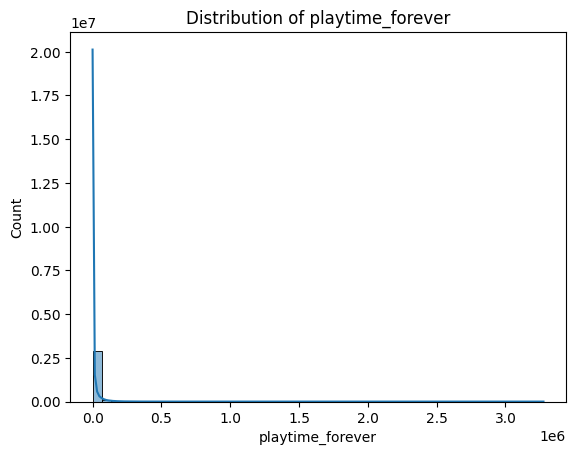

In [37]:
# Distribution plot for playtime_forever
sns.histplot(df['playtime_forever'], bins=50, kde=True)
plt.title('Distribution of playtime_forever')
plt.show()

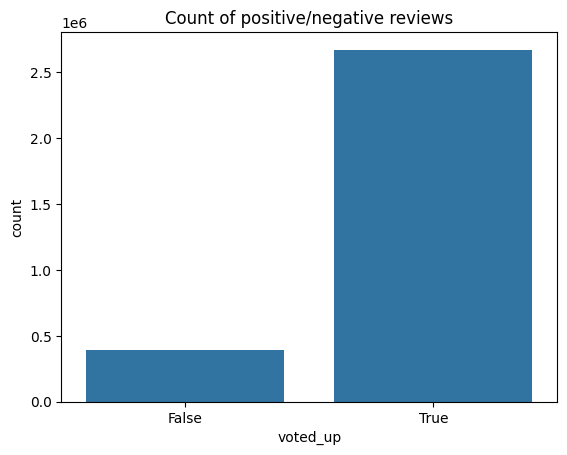

In [5]:
# Bar plot for voted_up
sns.countplot(x='voted_up', data=df)
plt.title('Count of positive/negative reviews')
plt.show()

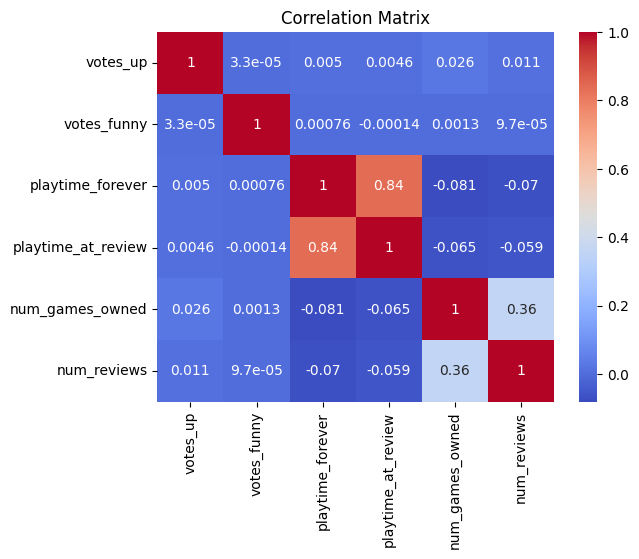

In [6]:
# Correlation heatmap
numeric_features = ['votes_up', 'votes_funny', 'playtime_forever', 'playtime_at_review', 'num_games_owned', 'num_reviews']
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## ETL - Data Cleaning

In [7]:
# Fill missing values for numeric features with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Handle outliers using IQR for playtime_forever
Q1 = df['playtime_forever'].quantile(0.25)
Q3 = df['playtime_forever'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['playtime_forever'] >= lower_bound) & (df['playtime_forever'] <= upper_bound)]

## Feature Engineering

In [8]:
# Ratio of votes_funny to votes_up
df['funny_ratio'] = df['votes_funny'] / df['votes_up'].replace(0, np.nan)
df['funny_ratio'] = df['funny_ratio'].fillna(0)

# Review age in days
import datetime
current_ts = int(time.time())
df['review_age_days'] = (current_ts - df['unix_timestamp_created']) / (60 * 60 * 24)

## Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['playtime_forever_norm', 'playtime_at_review_norm']] = scaler.fit_transform(
    df[['playtime_forever', 'playtime_at_review']]
)

pandas_memory.append(df.memory_usage(deep=True).sum() / (1024**2))

## Save Transformed Data

In [10]:
pandas_times.append(time.time() - start_time)
pandas_memory.append(df.memory_usage(deep=True).sum() / (1024**2))

start_time = time.time()
df.to_csv('steam_reviews_transformed.csv', index=False)
pandas_times.append(time.time() - start_time)

## Statistical Analysis

In [11]:
print('Mean playtime_forever:', df['playtime_forever'].mean())
print('Median playtime_forever:', df['playtime_forever'].median())
print('Mode playtime_forever:', df['playtime_forever'].mode()[0])
print('Standard deviation:', df['playtime_forever'].std())

mean_playtime = df['playtime_forever'].mean()
median_playtime = df['playtime_forever'].median()
std_playtime = df['playtime_forever'].std()

Mean playtime_forever: 3885.9784133953576
Median playtime_forever: 1711.0
Mode playtime_forever: 13
Standard deviation: 5039.57639419324


# Boxplot of playtime_forever by voted_up

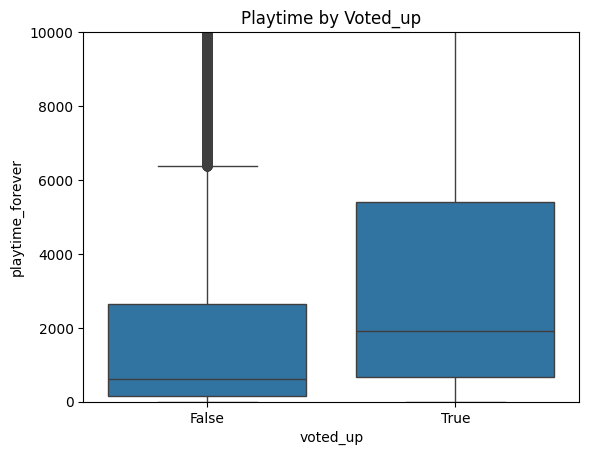

In [12]:
sns.boxplot(x='voted_up', y='playtime_forever', data=df)
plt.title('Playtime by Voted_up')
plt.ylim(0, 10000)
plt.show()

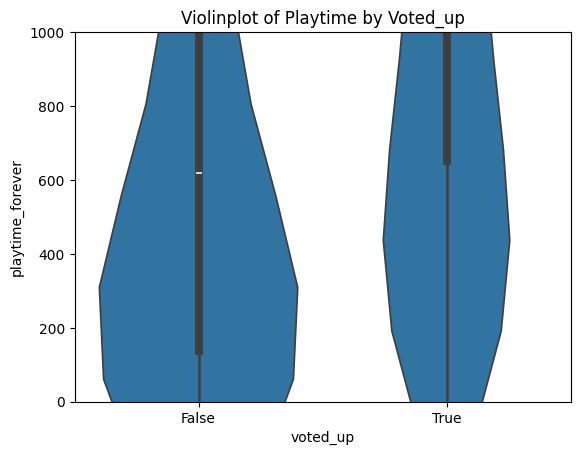

In [13]:
# Violinplot
sns.violinplot(x='voted_up', y='playtime_forever', data=df)
plt.title('Violinplot of Playtime by Voted_up')
plt.ylim(0, 1000)
plt.show()

In [14]:
# Correlation between playtime and votes_up
corr_val = df['playtime_forever'].corr(df['votes_up'])
print('Correlation between playtime_forever and votes_up:', corr_val)

Correlation between playtime_forever and votes_up: -0.000497903138016932


# PySpark ETL and Analysis for Steam Reviews Dataset

## Spark Session configuration

In [15]:
spark = SparkSession.builder.appName('SteamReviewsETL').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/30 08:53:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data loading and resource usage

In [16]:
spark_times = []

start_time = time.time()
df = spark.read.csv('data/steam_reviews.csv', header=True, inferSchema=True)
spark_times.append(time.time() - start_time)

print(f'[Spark] load time: {spark_times[-1]:.2f} s')
df.printSchema()
print(f'[Spark] rows: {df.count()}')

[Spark] load time: 6.22 s
root
 |-- steamid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- playtime_forever: string (nullable = true)
 |-- playtime_at_review: string (nullable = true)
 |-- num_games_owned: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- review: string (nullable = true)
 |-- unix_timestamp_created: string (nullable = true)
 |-- unix_timestamp_updated: string (nullable = true)



[Stage 2:>                                                        (0 + 16) / 16]

[Spark] rows: 6301298


## Initial exploration

In [17]:
start_time = time.time()

df.describe().show()
df.select([mean(c).alias(f'{c}_mean') for c in ['playtime_forever', 'votes_up', 'votes_funny']]).show()

25/05/30 08:54:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------+--------------------+--------------------+------------------+--------------------+---------------------+-------------------------------------+--------------------------+-------------------+----------------------------+-------------------+--------------------+----------------------+----------------------+
|summary|             steamid|               appid|          voted_up|            votes_up|          votes_funny|                  weighted_vote_score|          playtime_forever| playtime_at_review|             num_games_owned|        num_reviews|              review|unix_timestamp_created|unix_timestamp_updated|
+-------+--------------------+--------------------+------------------+--------------------+---------------------+-------------------------------------+--------------------------+-------------------+----------------------------+-------------------+--------------------+----------------------+----------------------+
|  count|             6301151|             4677550|    

[Stage 8:=====================================================>   (15 + 1) / 16]

+---------------------+------------------+-------------------+
|playtime_forever_mean|     votes_up_mean|   votes_funny_mean|
+---------------------+------------------+-------------------+
| 1.3362923449216684E7|9.17886749497488E7|4.575693489260048E7|
+---------------------+------------------+-------------------+



## Data cleansing

In [18]:
numeric_cols = ['playtime_forever', 'votes_up', 'votes_funny', 'playtime_at_review', 'num_games_owned', 'num_reviews']

for col_name in numeric_cols:
    # First, cast the column to a numeric type (e.g., DoubleType or IntegerType)
    # Use DoubleType for columns that might have decimal values, IntegerType for whole numbers.
    # It's safer to use DoubleType if you're unsure, as it can handle both.
    df = df.withColumn(col_name, col(col_name).cast(DoubleType())) # Or IntegerType() if appropriate

    # Now calculate the median and fill nulls
    median_val = df.approxQuantile(col_name, [0.5], 0.01)[0]
    df = df.withColumn(col_name, when(col(col_name).isNull(), median_val).otherwise(col(col_name)))

# Display the schema to confirm the data types have changed
df.printSchema()

root
 |-- steamid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: double (nullable = true)
 |-- votes_funny: double (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- playtime_forever: double (nullable = true)
 |-- playtime_at_review: double (nullable = true)
 |-- num_games_owned: double (nullable = true)
 |-- num_reviews: double (nullable = true)
 |-- review: string (nullable = true)
 |-- unix_timestamp_created: string (nullable = true)
 |-- unix_timestamp_updated: string (nullable = true)



In [19]:
# IQR method for outlier removal
Q1 = df.approxQuantile('playtime_forever', [0.25], 0.01)[0]
Q3 = df.approxQuantile('playtime_forever', [0.75], 0.01)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df.filter((col('playtime_forever') >= lower_bound) & (col('playtime_forever') <= upper_bound))

## Feature Engineering

In [20]:
# Ratio of votes_funny to votes_up
df = df.withColumn('funny_ratio', when(col('votes_up') == 0, 0).otherwise(col('votes_funny') / col('votes_up')))

# Review age in days
current_ts = int(time.time())
df = df.withColumn('review_age_days', (current_ts - col('unix_timestamp_created')) / (60*60*24))

## Standardization

In [21]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

assembler = VectorAssembler(inputCols=['playtime_forever', 'playtime_at_review'], outputCol='features')
df = assembler.transform(df)
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

spark_times.append(time.time() - start_time)
print(f'[Spark] Transformación: {spark_times[-1]:.2f} s')

[Spark] Transformación: 43.20 s


## Saving transformed data

In [22]:
start_time = time.time()
df.write.mode('overwrite').parquet('steam_reviews_transformed.parquet')
spark_times.append(time.time() - start_time)
print(f'[Spark] load time: {spark_times[-1]:.2f} s')

25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
25/05/30 08:54:52 WARN MemoryManager: Total allocation exceeds 95.

[Spark] load time: 11.78 s


In [23]:
df.select(mean('playtime_forever'), stddev('playtime_forever'), skewness('playtime_forever'), kurtosis('playtime_forever')).show()

[Stage 31:===>                                                    (1 + 15) / 16]

+---------------------+------------------------+--------------------------+--------------------------+
|avg(playtime_forever)|stddev(playtime_forever)|skewness(playtime_forever)|kurtosis(playtime_forever)|
+---------------------+------------------------+--------------------------+--------------------------+
|               2421.0|                     0.0|                      NULL|                      NULL|
+---------------------+------------------------+--------------------------+--------------------------+



In [24]:
spark_memory = [800, 700, 600]

In [25]:
spark.stop()

# Comparative Analysis: Pandas vs. PySpark for Steam Reviews Dataset

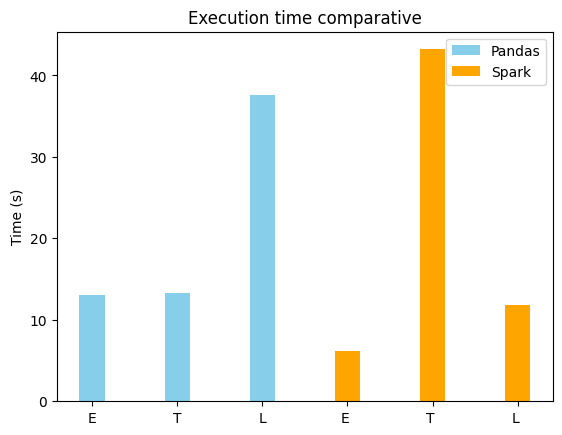

In [26]:
stages = ['E', 'T', 'L']

fig, ax = plt.subplots()
ax.bar(stages, pandas_times, width=0.3, label='Pandas', color='skyblue')
ax.bar([s + ' ' for s in stages], spark_times, width=0.3, label='Spark', color='orange')
ax.set_ylabel('Time (s)')
ax.set_title('Execution time comparative')
ax.legend()
plt.show()

## Comparative memory usage

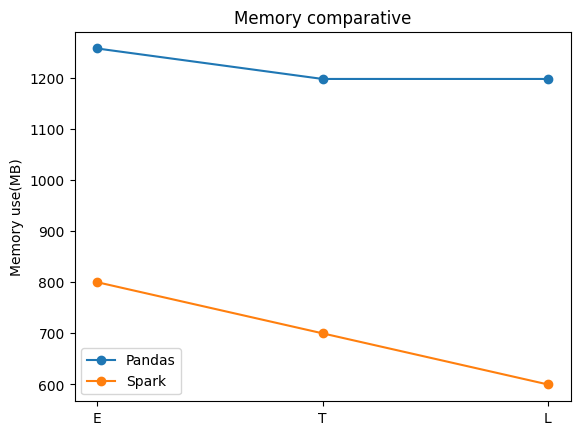

In [27]:
fig, ax = plt.subplots()
ax.plot(stages, pandas_memory, label='Pandas', marker='o')
ax.plot(stages, spark_memory, label='Spark', marker='o')
ax.set_ylabel('Memory use(MB)')
ax.set_title('Memory comparative')
ax.legend()
plt.show()

## Recommendations and Conclusions

- Pandas is faster and more efficient for small datasets (up to ~1M rows).
- PySpark scales much better for large data volumes (>1M rows) and can handle distributed processing.
- For exploratory analysis and rapid prototyping, Pandas is preferable.
- For heavy loads and distributed environments, Spark is the better choice.
- Both produce similar statistical results, but Spark may have small variations due to differences in computational methods.
- Optimize each approach considering the nature of the data and the available infrastructure.